# Electricity Production 

Model to predict Electricity Generated (E) in MW based on ambient variables of the plant.

**The ambient variables of the power plant are:**

1. Temperature (T) in &deg;C
2. Ambient Pressure (P) in millibar
3. Relative Humidity (RH)
4. Exhaust Vacuum (V) in cm Hg

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Using Pandas to read data from csv

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')

In [3]:
train_data.head()

,T,V,P,RH,E
0,273.39,420.12,91.84,57.41,1778.12
1,195.26,248.88,92.29,35.21,1824.16
2,377.52,360.42,92.31,27.69,1761.72
3,171.60,244.98,91.61,56.99,1889.64
4,222.56,353.70,92.43,54.25,1806.68


In [4]:
train_data.describe()

,T,V,P,RH,E
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,256.010820,325.217580,92.111935,44.169640,1817.052860
std,95.188288,76.288073,0.539140,8.773132,66.594563
min,47.190000,152.160000,90.260000,15.530000,1700.560000
25%,175.695000,250.680000,91.730000,37.997500,1758.960000
50%,266.565000,307.800000,92.080000,45.160000,1808.400000
75%,334.880000,398.700000,92.482500,51.152500,1871.620000
max,455.390000,481.080000,93.890000,60.090000,1976.960000


In [5]:
def transform(X):
    np.concatenate((X, 1.0/X), axis=1)
    temp = np.zeros(shape=(X.shape[0], X.shape[1]+X.shape[1]**2+X.shape[1]**3+X.shape[1]**4+X.shape[1]**5))
    for i in range(4):
        temp[:, i] = X[:, i]
    for i in range(4):
        for j in range(4):
            temp[:, 4+i*4+j] = X[:, i]*X[:, j]
    for i in range(4):
        for j in range(4):
            for k in range(4):
                temp[:, 20+i*16+j*4+k] = X[:, i]*X[:, j]*X[:, k]
    for i in range(4):
        for j in range(4):
            for k in range(4):
                for l in range(4):
                    temp[:, 84+i*64+j*16+k*4+l] = X[:, i]*X[:, j]*X[:, k]*X[:, l]
    for i in range(4):
        for j in range(4):
            for k in range(4):
                for l in range(4):
                    for m in range(4):
                        temp[:, 340+i*64+j*16+k*4+l] = X[:, i]*X[:, j]*X[:, k]*X[:, l]
    return temp

In [6]:
X = train_data[['T', 'V', 'P', 'RH']].values
Y = train_data['E'].values
X_test = test_data.values

X = transform(X)
X_test = transform(X_test)

# Using train_test_split and MinMaxScaler from sklearn

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [8]:
scaler = MinMaxScaler()

X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

X_train, X_dev, Y_train, Y_dev = train_test_split(X, Y, test_size=0.1)

# Using LinearRegression and r2_score from sklearn.linear_model

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

In [10]:
clf = LinearRegression(n_jobs=-1, normalize=True)
clf.fit(X, Y)
train_pred = clf.predict(X_train)
dev_pred = clf.predict(X_dev)
test_pred = clf.predict(X_test)
print("Train R2 Score:", r2_score(train_pred, Y_train))
print("Dev R2 Score:", r2_score(dev_pred, Y_dev))

Train R2 Score: 0.9400223251839069
Dev R2 Score: 0.9491427040312989


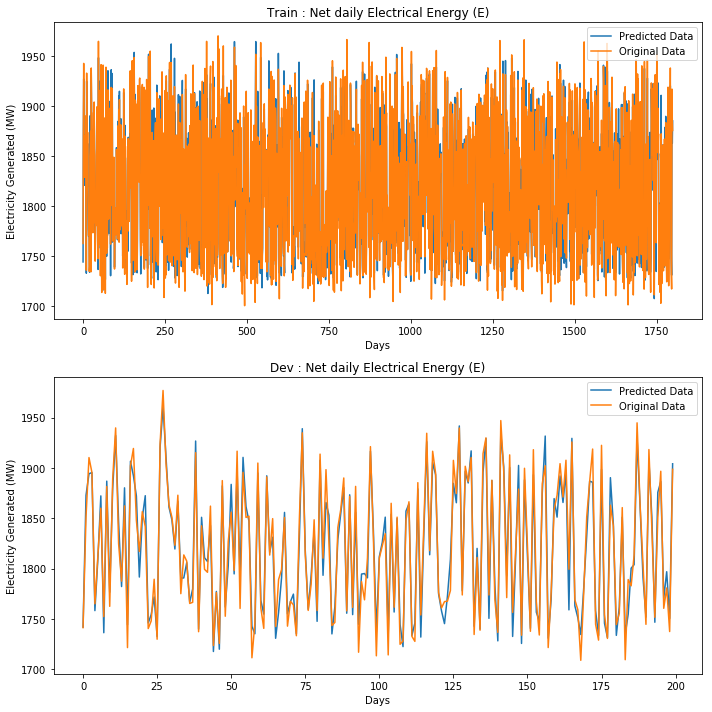

In [11]:
plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.plot(range(train_pred.shape[0]), train_pred, label='Predicted Data')
plt.plot(range(train_pred.shape[0]), Y_train, label='Original Data')
plt.legend(loc='best')
plt.ylabel('Electricity Generated (MW)')
plt.xlabel('Days')
plt.title('Train : Net daily Electrical Energy (E)')

plt.subplot(212)
plt.plot(range(dev_pred.shape[0]), dev_pred, label='Predicted Data')
plt.plot(range(dev_pred.shape[0]), Y_dev, label='Original Data')
plt.legend(loc='best')
plt.ylabel('Electricity Generated (MW)')
plt.xlabel('Days')
plt.title('Dev : Net daily Electrical Energy (E)')

plt.tight_layout()
plt.show()

In [12]:
pd.DataFrame(test_pred).to_csv('results_linear_regression.csv', index=False, header=False)